In [3]:
import numpy as np
import matplotlib.pyplot as plt
# from soft_smooth import *

In [4]:
ebandMeans = np.array([
      6.437500, 6.250000, 5.750000, 5.312500, 5.062500,
      4.812500, 4.500000, 4.375000, 4.875000, 4.687500,
      4.562500, 4.437500, 4.875000, 4.625000, 4.312500,
      4.500000, 4.375000, 4.625000, 4.750000, 4.437500,
      3.750000, 3.750000, 3.750000, 3.750000, 3.750000
]).astype('float')
band_defs = np.array([0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 12, 14, 16, 20, 24, 28, 34, 40, 48, 60, 78, 100])*8

def smooth_vector(vec, k, lowpass='pyramid'):
    """ applies smoothing with rect kernel of size 2k + 1 """
    
    if lowpass == 'rect':
        kernel = np.ones(2 * k + 1) / (2 * k + 1)
    elif lowpass == 'pyramid':
        kernel = np.concatenate((np.arange(1, k+2), np.arange(k, 0, -1)))
        kernel = kernel / np.sum(kernel)
    
    # extend vector by repetition
    extended_vec = np.concatenate(
        (
            vec[0] * np.ones(k),
            vec,
            vec[-1] * np.ones(k)
        ))
    
    smoothed_vec = np.convolve(extended_vec, kernel, mode='valid')
    
    return smoothed_vec

def denormalize_mdct(input_norm_log, input_mdct_normalized):
    input_norm_linear = 2**(input_norm_log)

    mdct = np.copy(input_mdct_normalized)
    
    for i in range(band_defs.shape[0] - 1):
        mdct[:,:, band_defs[i] : band_defs[i + 1]] *= input_norm_linear[:,:,i:i+1]
    mdct[:,:, band_defs[-1]:] *= np.tile(input_norm_linear[:,:,-1:],[1,1,160])

    return mdct

def normalize_mdct(input_norm_log, mdct):
    input_norm_linear = 2**(input_norm_log)

    mdct_normalized = np.copy(mdct)
    
    for i in range(band_defs.shape[0] - 1):
        mdct_normalized[:,:, band_defs[i] : band_defs[i + 1]] /= input_norm_linear[:,:,i:i+1]
    mdct_normalized[:,:, band_defs[-1]:] /= np.tile(input_norm_linear[:,:,-1:],[1,1,160])

    return mdct_normalized

def get_scale_factors(input_norm_log,k1 = 2,k2 = 8):
    """
    Add ebandmeans to input 
    """

    input_energy_linear = 2**(2*(input_norm_log))
    input_energy_log = np.log(input_energy_linear)

    input_energy_log_smoothed = np.apply_along_axis(lambda inp: smooth_vector(inp, k1, 'pyramid'), axis=-1, arr=input_energy_log)
    
    smoothing_coefficients = np.zeros((input_norm_log.shape[0],input_norm_log.shape[1],960))
    for i in range(band_defs.shape[0] - 1):
        smoothing_coefficients[:,:, band_defs[i] : band_defs[i + 1]] = np.tile(input_energy_log_smoothed[:,:,i:i+1],[1,1,band_defs[i+1] - band_defs[i]])
    
    scale_factors = np.apply_along_axis(lambda inp: smooth_vector(inp, k2, 'pyramid'), axis=-1, arr=smoothing_coefficients)

    return (np.exp(scale_factors/2) + 1e-8)

def shape_spectrum(input_norm_log, input_mdct_normalized,k1 = 2, k2 = 8):

    mdct = denormalize_mdct(input_norm_log, input_mdct_normalized)
    scale_factors = get_scale_factors(input_norm_log,k1,k2)

    return mdct / scale_factors

def invert_shape_spectrum(input_norm_log, input_mdct_shaped,k1 = 2, k2 = 8):
    scale_factors = get_scale_factors(input_norm_log,k1,k2)
    input_mdct_unnormalized = input_mdct_shaped * scale_factors
    input_mdct_normalized = normalize_mdct(input_norm_log, input_mdct_unnormalized)

    return input_mdct_normalized

In [67]:
def test(inp_E,kE,ks):
    rootE = 2**(inp_E + ebandMeans[:21]) #square_root energy
    smooth_E = smooth_vector(rootE,kE)
    band_norms = np.zeros(800)
    for i in range(band_defs.shape[0] - 1):
        # band_norms[:,:, band_defs[i] : band_defs[i + 1]] = iE[:,:,i:i+1]/smooth_E[:,:,i:i+1]
        band_norms[band_defs[i] : band_defs[i + 1]] = smooth_E[i:i+1]

    sf = smooth_vector(band_norms,ks)

    for i in range(band_defs.shape[0] - 1):
        sf[band_defs[i] : band_defs[i + 1]] = 1.0/sf[band_defs[i] :band_defs[i + 1]]
        
    return smooth_E,sf

In [5]:
# Loading CELT MDCTs
ee_celt = np.fromfile("../../datasets/spe_test_48kfull_bandLogE",dtype='float32')
mm_celt = np.fromfile("../../datasets/spe_test_48kfull_mdctnormalized",dtype='float32')

sequence_size_shape = 1
nb_features_cepstral = 960
nb_features = 21
nb_sequences_shape = len(mm_celt)//(nb_features_cepstral*sequence_size_shape)
nb_sequences_E = len(ee_celt)//(nb_features*sequence_size_shape)

mm_celt = mm_celt[:nb_sequences_shape*sequence_size_shape*nb_features_cepstral]
mm_celt = np.reshape(mm_celt, (nb_sequences_shape, sequence_size_shape, nb_features_cepstral))
mm_celt = mm_celt[:(int)(1*nb_sequences_shape), :, :800]
mm_celt = np.concatenate((mm_celt.squeeze(),np.zeros((mm_celt.shape[0],160))),axis = -1)
mm_celt = mm_celt.squeeze()

ee_celt = ee_celt[:nb_sequences_E*sequence_size_shape*nb_features]
ee_celt = np.reshape(ee_celt, (nb_sequences_E, sequence_size_shape, nb_features))
ee_celt = ee_celt[:(int)(1*nb_sequences_E), :, :]
ee_celt = ee_celt.squeeze()

In [6]:
ee_celt = np.expand_dims(ee_celt,0)
mm_celt = np.expand_dims(mm_celt,0)

In [7]:
shaped_spec = shape_spectrum(ee_celt + ebandMeans[:21], mm_celt,2,8)
inv_shaped_spec = invert_shape_spectrum(ee_celt + ebandMeans[:21],shaped_spec,2,8)

In [8]:
np.linalg.norm(inv_shaped_spec - mm_celt)

1.2787017165000756e-14

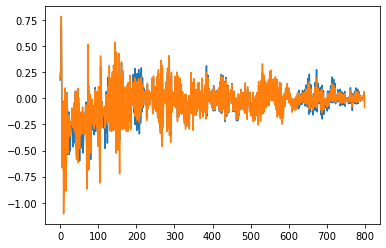

In [9]:
plt.plot(mm_celt[0,300,:800])
plt.plot(shaped_spec[0,300,:800])

In [10]:
sf = get_scale_factors(inp + ebandMeans[:21])

NameError: name 'inp' is not defined

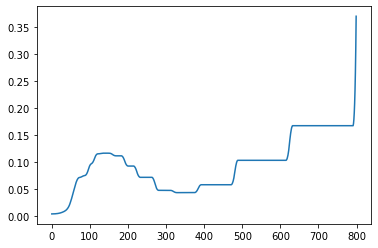

In [147]:
plt.plot(1.0/sf[0,0,:800])

In [25]:
2**(inp + ebandMeans[:21])

array([[[280.97451363, 308.62385579, 367.56664136,  83.72483558,
         121.83363224, 149.65293279,  23.11423553,  10.34202079,
           8.34689142,  51.18161101,   5.90402241,   4.14460394,
          18.09519886,   7.00040145,   8.91185916,  10.48059123,
          30.29275365,  36.0205006 ,  24.67534058,   7.4968477 ,
           4.3884612 ]]])

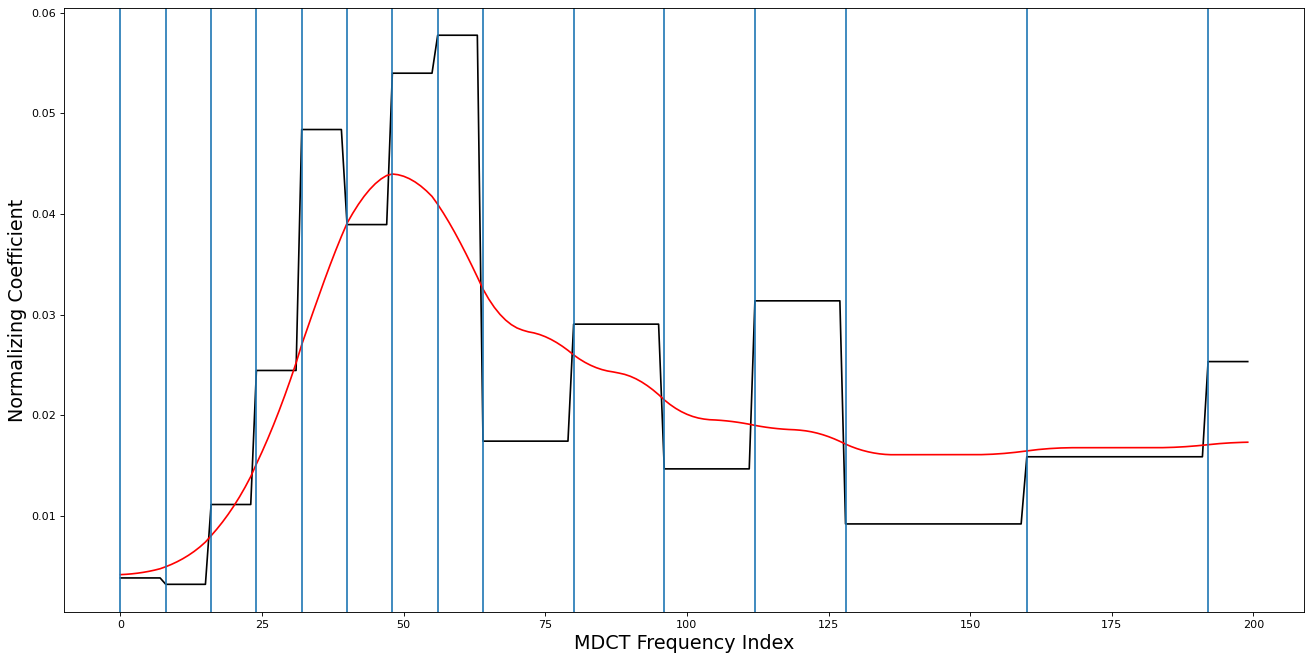

In [20]:
sf_00 = get_scale_factors(ee_celt + ebandMeans[:21],0,0)[0,300,:]
sf_28 = get_scale_factors(ee_celt + ebandMeans[:21],2,8)[0,300,:]

plt.figure(figsize=(20, 10), dpi=80)
# plt.title("Smoothing Coefficients")
plt.plot(1.0/sf_00[:200],'k')
plt.plot(1.0/sf_28[:200],'r')
for j in band_defs:
    if j >= 200:
        continue
    plt.axvline(j)
plt.xlabel("MDCT Frequency Index",fontsize = "xx-large")
plt.ylabel("Normalizing Coefficient",fontsize = "xx-large")
plt.savefig('smoothing.png')

In [71]:
mm_celt_smoothnorm, sf = smoother(ee_celt,mm_celt)

In [72]:
np.linalg.norm(mm_celt - mm_celt_smoothnorm)

122.29425187017355

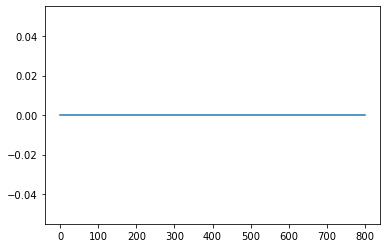

In [74]:
plt.plot(sf[0,76,:] -sf_28)
# plt.plot(sf_28)

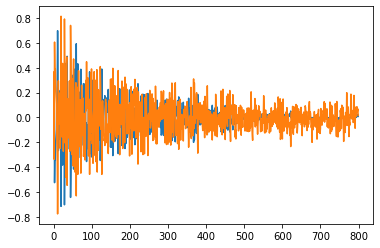

In [54]:
plt.plot(mm_celt_smoothnorm[0,0,:] - mm_celt[0,0,:])
plt.plot(mm_celt[0,0,:])

In [55]:
mm_celt_recon = inverse_smoother(ee_celt,mm_celt_smoothnorm)

In [56]:
np.linalg.norm(mm_celt_recon - mm_celt)

2.068542468816007e-14

In [64]:
np.linalg.norm(mm_celt_recon[0,0,:8])

0.9999999735375256

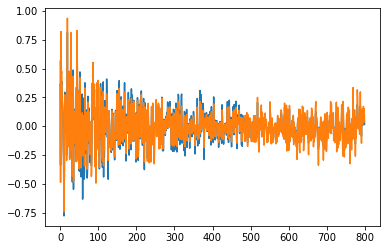

In [66]:
plt.plot(mm_celt[0,0,:])
plt.plot(mm_celt_smoothnorm[0,0,:])

In [62]:
def smooth_vector(vec):
    """ applies smoothing with rect kernel of size 2k + 1 """
    k = 2
    kernel = np.ones(2 * k + 1) / (2 * k + 1)
    
    # extend vector by repetition
    extended_vec = np.concatenate(
        (
            vec[0] * np.ones(k),
            vec,
            vec[-1] * np.ones(k)
        ))
    
    smoothed_vec = np.convolve(vec, kernel, mode='same')
    
    return smoothed_vec

In [ ]:
def smoother(inp_E, inp_mdct, band_defs):
    """
    Smoothing Energies to reduce variance, followed by re-smoothing the "new-energy" normalized mdcts for further variance reduction
    func is the function that performs the (per-axis) smoothing, shared by both
    inp_E of shape (batch,seq_length,:)
    inp_mdct of shape (batch,seq_length,:)
    """
    smooth_E = np.apply_along_axis(func, axis=-1, arr=inp_E)
    
    sf = np.zeros(inp_mdct.shape[-1])
    for i in range(num_bands - 1):
        sf[band_limits[i] : band_limits[i + 1]] = env_smoothed[i]
    
    sf[band_limits[-1]:] = env_smoothed[-1]
    
    
    return smoothed_E

In [57]:
# example

env = np.exp(np.random.rand(5,100,num_bands))

In [36]:
pre = np.tile(env[:,:,:1],[1,1,2])
post = np.tile(env[:,:,-1:],[1,1,2])

In [41]:
print(pre.shape,env.shape,post.shape)

(5, 100, 2) (5, 100, 22) (5, 100, 2)


In [42]:
extended_vec = np.concatenate((pre,env,post),-1)

In [63]:
op_axis = np.apply_along_axis(smooth_vector, axis=-1, arr=env)

In [64]:
np.linalg.norm(op_axis - env)

51.583989380209836

In [47]:
smoothed_E = np.convolve(extended_vec, np.ones(2), mode='same')

ValueError: object too deep for desired array

In [35]:
post[0,0,0]

1.0591127143549373

In [34]:
env[0,0,-1]

1.0591127143549373

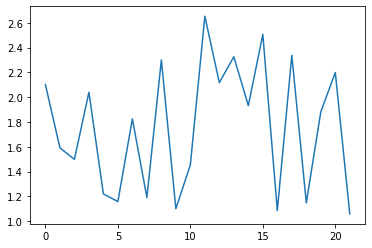

In [26]:
plt.plot(env[0][0])

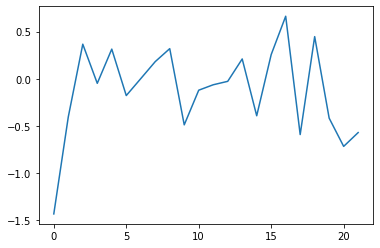

In [23]:
# smooth energies over bands first
env_smoothed = smooth_vector(env, 2)

plt.plot(env_smoothed - env)

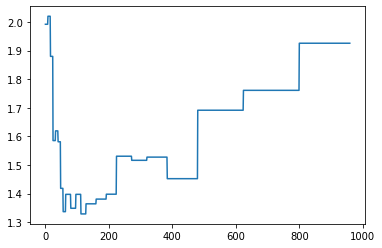

In [13]:
# generate scale factors
sf = np.zeros(N)

for i in range(num_bands - 1):
    sf[band_limits[i] : band_limits[i + 1]] = env_smoothed[i]
    
sf[band_limits[-1]:] = env_smoothed[-1]

plt.plot(sf)

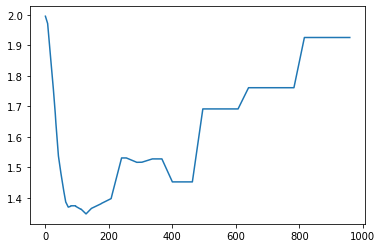

In [14]:
sf_smoothed = smooth_vector(sf, 16)

plt.plot(sf_smoothed)